<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<H4 align='center'> Integrantes: Pablo Aguirre, Rol: 201473555-3; Jorge Aliste, Rol: 201473538-3 </H4>
<hr style="height:2px;border:none"/>

## Pregunta 3: *Taxi Trip Duration*

El objetivo de esta pregunta es predecir la duración del viaje de un taxi en Nueva York. La métrica de evaluación será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

In [1]:
from geopy.distance import great_circle
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler

from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import losses

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [3]:
import pandas as pd
df = pd.read_csv("train.csv")
print(df.info())
print(df.head())
output = df['trip_duration'].values
output

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06

array([ 455,  663, 2124, ...,  764,  373,  198], dtype=int64)

Dentro del dataset se encuentran 10 variables y 2 datos que son de identificación. 
+ Id: string que correspende a la id que se le da al viaje, es para identificar y no sirve como variable.
+ vendor_id: entero que corresponde al código asociado al vendedor. Considerado variable ya que cada conductor conduce de distinta forma favoreciendo o perjudicando el tiempo de viaje.
+ pickup_datetime, dropoff_datetime: strings que permiten conocer el tiempo en que se tomó y dejó a los pasajeros. El tiempo puede influir debido al tráfico.
+ passenger_count: entero con la cantidad de pasajeros. Este podría influir debido a que un pasajero se baje antes.
+ pickup_longitude, pickup_latitude, dropoff_latitude, dropoff_latitude: variables tipo float que proporciona información de la ubicación en que se toma y deja al pasajero. El sector donde ocurre esto influye en los tiempos.
+ store_and_fwd_flag: tipo char que determina si los datos fueron guardados en el almacenamiento del vehículo o si fueron enviados inmediatamente. Este dato no debe influir en el tiempo.
+ trip_duration: variable entera que indica el tiempo en que demora en realizar el viaje. Esta sería la variable dependiente.

Ahora, para un mejor análisis se genera un boxplot de la variable trip_duration:

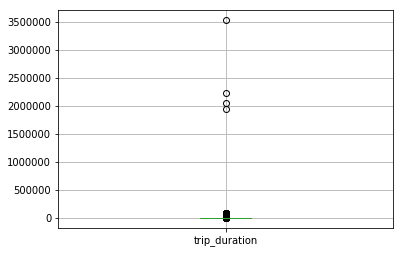

In [4]:
fig, ax = plt.subplots()

box = df.boxplot(ax=ax, column='trip_duration') 
plt.show()

El boxplot resultante indica que hay varios outliers que ni siquiera permiten ver bien el boxplot. Por lo que usando un histograma y acotando el rango se obtiene el siguiente histograma.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FD520E8CF8>]],
      dtype=object)

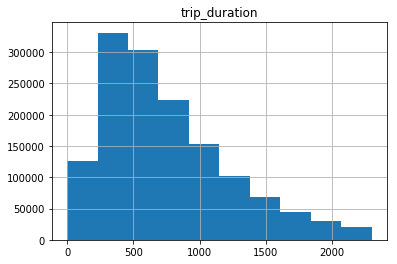

In [5]:
df.hist(column=['trip_duration'], range = (0,2300))

Con el histrograma se puede notar que la mayor cantidad de viajes toma un tiempo entre 250 segundos y 750.

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

Para un mejor análisis, se eliminan los outliers. Como estos datos son muy distintos a los de la muestra, pueden afectar al entrenamiento de muy mala manera.

In [6]:
df = df[(df['trip_duration']<=1800)]

Se genera nuevamente el boxplot:

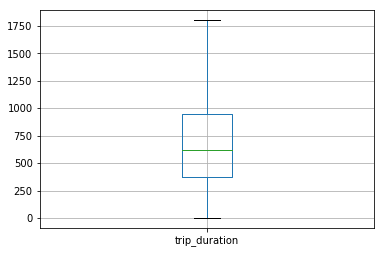

In [7]:
df.boxplot(column=['trip_duration'])

Ahora, se puede notar que la mediana se encuentra de los 500 segundos y como la caja se ve uniforme, podemos decir que la cantidad de datos se distribuye normalmente alrededor de la mediana.

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.  

In [8]:
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0
5,6,-73.982857,40.742195,-73.992081,40.749184,443,22,5,1,0.011572,1.098944,315.004404,0,0


El objetivo del pre-procesamiento es generar nuevos atributos como combinaciones de otros pre-existentes. Esto puede servir ya que algunos atributos se potencian al estar en conjunto con otros.

> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.

In [9]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
print("Entrenamiento: ", X_train_scaled.shape)
print("Prueba: ", X_test_scaled.shape)

Entrenamiento:  (941868, 13)
Prueba:  (403658, 13)


El conjunto de entrenamiento cuenta con 941868 registros, mientras que el conjunto de prueba cuenta con 403658. Ambos con 13 atributos para cada registro.

Se elige `RobustScaler` ya que es mas resistente a los outliers y podría favorecer la generalización por parte del modelo.

> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

El modelo por utilizar es una Red Neuronal Feed Forward. Se eligió este modelo debido a la gran cantidad de registros que se tienen para el input. Una red con muchas neuronas puede aprovechar esta cantidad más que una SVR.

In [11]:
modelNNR = Sequential()
modelNNR.add(Dense(512, input_dim=X_train_scaled.shape[1], kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(256, kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(128, kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(64, kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(1, kernel_initializer='normal'))

modelNNR.compile(loss=losses.mean_squared_logarithmic_error, optimizer='RMSprop')

modelNNR.fit(X_train_scaled, y_train, epochs=10, batch_size=1024, verbose=1)

Epoch 1/10
941868/941868 [==============================] - 10s 11us/step - loss: 0.7550
Epoch 2/10
941868/941868 [==============================] - 9s 9us/step - loss: 0.2271
Epoch 3/10
941868/941868 [==============================] - 9s 9us/step - loss: 0.2146
Epoch 4/10
941868/941868 [==============================] - 9s 9us/step - loss: 0.2079
Epoch 5/10
941868/941868 [==============================] - 9s 9us/step - loss: 0.2035A: - ETA: 1s - ETA: 0s - loss: 0.2
Epoch 6/10
941868/941868 [==============================] - 9s 9us/step - loss: 0.2000
Epoch 7/10
941868/941868 [==============================] - 9s 9us/step - loss: 0.1966
Epoch 8/10
941868/941868 [==============================] - 10s 11us/step - loss: 0.1939
Epoch 9/10
941868/941868 [==============================] - 11s 11us/step - loss: 0.1916
Epoch 10/10
941868/941868 [==============================] - 10s 10us/step - loss: 0.1898


In [12]:
print("ERROR RMSLE de training: ", rmsle(modelNNR.predict(X_train_scaled),y_train))
print("ERROR RMSLE de test: ", rmsle(modelNNR.predict(X_test_scaled),y_test))

ERROR RMSLE de training:  [0.37610036]
ERROR RMSLE de test:  [0.37740209]


Mientras mas cercano a cero sea el RMSLE obtenido, mejor es el modelo. El error de entrenamiento y el de prueba son parecidos por lo que no se está produciendo overfitting.

> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?

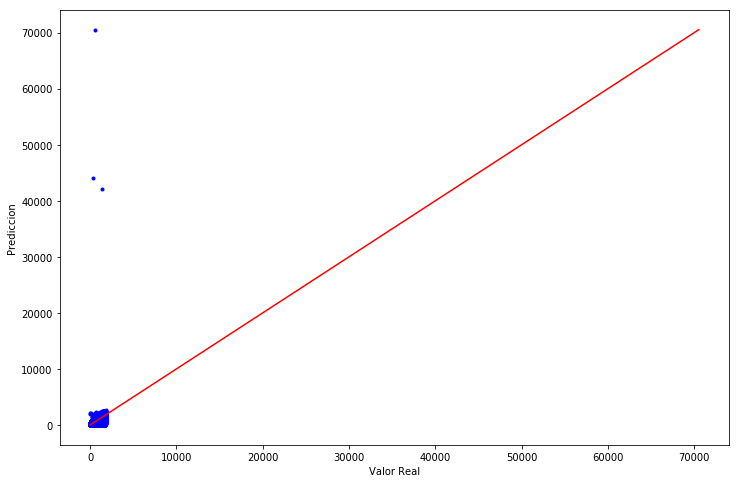

In [13]:
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
    
graficar_predicciones(y_test,modelNNR.predict(X_test_scaled))

El comportamiento esperado es que los puntos azules se ubiquen en la recta roja. Esto significa que el modelo es capaz de generalizar bien y la regresión es adecuada. 
En este caso los puntos azules están ubicados al comienzo de la recta roja, exceptuando algunos valores que se encuentran sobre la recta, por lo que la generalización no es mala.

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 


Para el error de validación se decidió crear un conjunto de validación a partir del conjunto de entrenamiento original ya que se tienen muchos datos y sería excesivo y costoso usar calidación cruzada. La proporción es 70% entrenamiento y 30% validación.

In [14]:
puntoDeCorte = X_train_scaled.shape[0]*0.7

X_train_scaled2 = X_train_scaled[:round(puntoDeCorte)]
X_val_scaled = X_train_scaled[round(puntoDeCorte):]

y_train2 = y_train[:round(puntoDeCorte)]
y_val = y_train[round(puntoDeCorte):]

In [15]:
modelNNR_2 = Sequential()
modelNNR_2.add(Dense(512, input_dim=13, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(512, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(256, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(256, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(128, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(128, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(1, kernel_initializer='normal'))

modelNNR_2.compile(loss=losses.mean_squared_logarithmic_error, optimizer='RMSprop')

modelNNR_2.fit(X_train_scaled2, y_train2, epochs=10, batch_size=512, verbose=1)

Epoch 1/10
659308/659308 [==============================] - 15s 23us/step - loss: 0.3769 0s - loss: 0.
Epoch 2/10
659308/659308 [==============================] - 16s 25us/step - loss: 0.2141
Epoch 3/10
659308/659308 [==============================] - 17s 26us/step - loss: 0.2006
Epoch 4/10
659308/659308 [==============================] - 17s 26us/step - loss: 0.1923
Epoch 5/10
659308/659308 [==============================] - 17s 27us/step - loss: 0.1880
Epoch 6/10
659308/659308 [==============================] - 17s 26us/step - loss: 0.1844
Epoch 7/10
659308/659308 [==============================] - 18s 27us/step - loss: 0.1815
Epoch 8/10
659308/659308 [==============================] - 15s 22us/step - loss: 0.1794
Epoch 9/10
659308/659308 [==============================] - 15s 22us/step - loss: 0.1776
Epoch 10/10
659308/659308 [==============================] - 17s 26us/step - loss: 0.1764


In [16]:
print("ERROR RMSLE de training: ", rmsle(modelNNR_2.predict(X_train_scaled2),y_train2))
print("ERROR RMSLE de validacion: ", rmsle(modelNNR_2.predict(X_val_scaled),y_val))

ERROR RMSLE de training:  [0.36558604]
ERROR RMSLE de validacion:  [0.36698651]


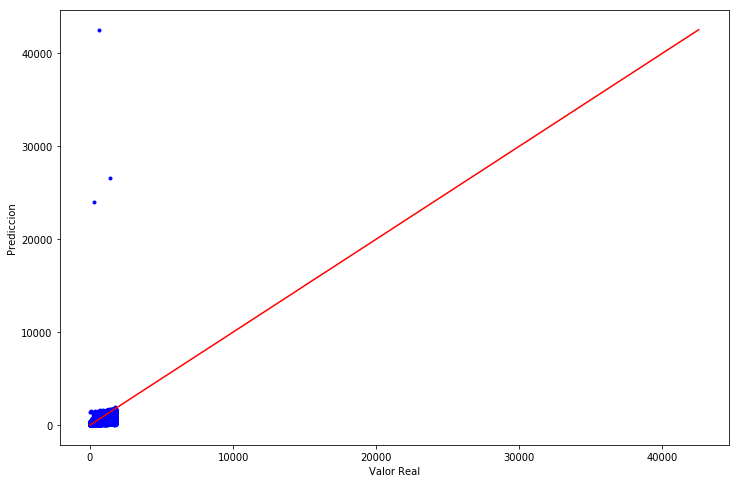

In [17]:
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
    
graficar_predicciones(y_test,modelNNR_2.predict(X_test_scaled))

No se logró una mejora significativa respecto al modelo anterior por lo que la clave puede estar en una buena ingeniería de atributos.

> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).

No se pudo implementar.

> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.

No se pudo implementar.

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.

No se pudo implementar.